In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from typing import Tuple

%matplotlib inline

In [2]:
def levendistance(a: np.ndarray, b: np.ndarray) -> int:
    n: int = len(a) 
    m: int = len(b)
    if n > m:
        a, b = b, a
        n, m = m, n

    current_row = range(n + 1)
    for i in range(1, m + 1):
        previous_row, current_row = current_row, [i] + [0] * n
        for j in range(1, n + 1):
            add: int = previous_row[j] + 1
            delete: int = current_row[j - 1] + 1
            change: int = previous_row[j - 1] 
            if a[j - 1] != b[i - 1]:
                change += 1
            current_row[j] = min(add, delete, change)

    return current_row[n]

In [3]:
class JustRNN:
    def __init__(self, max_n: int, hidden_dim: int) -> None:
        self.max_n: int      = max_n
        self.hidden_dim: int = hidden_dim
            
        self.Wxh: np.ndarray = 0.01 * np.random.randn(hidden_dim, max_n + 1)
        self.Whh: np.ndarray = 0.01 * np.random.randn(hidden_dim, hidden_dim)
        self.Why: np.ndarraynp.ndarray = 0.01 * np.random.randn(max_n, hidden_dim)
        
    def forward(self, X: np.ndarray, y: np.ndarray, size: int) -> Tuple[np.ndarray, List[np.ndarray], 
                                                                        List[np.ndarray], float]:  
        hidden_states: List[np.ndarray] = []
        hidden_states.append(np.zeros((self.hidden_dim, 1)))    
        
        probs: List[np.ndarray] = []
        prediction: np.ndarray = np.zeros(size, dtype=np.int32)
        loss: float = 0
        
        pos: int
        for pos in range(size):
            X[self.max_n] = pos
            hidden: np.ndarray = np.tanh(np.dot(self.Wxh, X) + np.dot(self.Whh, hidden_states[-1]))
            hidden_states.append(hidden)

            output: np.ndarray = np.dot(self.Why, hidden)
            prob: np.ndarray = np.exp(output) / np.sum(np.exp(output)) 
            probs.append(prob)

            loss += -np.log(prob[y[pos],0]) 

            prediction[pos] = np.argmax(prob)
            
        return prediction, hidden_states, probs, loss
    
    def backward(self, X: np.ndarray, y: np.ndarray, size: int, 
                 hidden_states: List[np.ndarray], probs: List[np.ndarray]) -> Tuple[np.ndarray, np.ndarray, 
                                                                                    np.ndarray]:
        dWxh: np.ndarray = np.zeros_like(self.Wxh)
        dWhh: np.ndarray = np.zeros_like(self.Whh)
        dWhy: np.ndarray = np.zeros_like(self.Why)
        dhnext: np.ndarray = np.zeros_like(hidden_states[0])
        
        pos: int
        for pos in reversed(range(size)):
            X[self.max_n] = pos
            dy: np.ndarray = np.copy(probs[pos])
            dy[y[pos]] -= 1 

            dWhy += np.dot(dy, hidden_states[pos].T)
            
            dh: np.ndarray = np.dot(self.Why.T, dy) + dhnext 
            dhraw: np.ndarray = (1 - hidden_states[pos] * hidden_states[pos]) * dh 
            
            dWxh += np.dot(dhraw, X.T)
            dWhh += np.dot(dhraw, hidden_states[pos-1].T)
            
            dhnext = np.dot(self.Whh.T, dhraw)
            
        for dparam in [dWxh, dWhh, dWhy]:
            # clip to mitigate exploding gradients
            np.clip(dparam, -5, 5, out=dparam) 
            
        return dWxh, dWhh, dWhy
        
    def train(self, max_examples: int, learning_rate: float, max_seq_len: int, lr_lambda: float = 0.4, 
            lr_reduce_rate: int = 500, info_rate: int = 100) -> List[float]:
        
        distnaces: int = 0
        dist_list: List[float] = []
        
        for i in range(max_examples):
            sequence_size: int = max_seq_len
            
            X: np.ndarray = np.random.randint(self.max_n, size=sequence_size)
            y: np.ndarray = np.sort(X)

            one_hot: np.ndarray = np.zeros((self.max_n + 1, 1))
            one_hot[X, :] = 1
            
            prediction: np.ndarray
            hidden_states: List[np.ndarray]
            probs: List[np.ndarray]
            loss: float
            prediction, hidden_states, probs, loss = self.forward(one_hot, y, sequence_size)
                
            distnaces += levendistance(prediction, y)
            
            dWxh, dWhh, dWhy = self.backward(one_hot, y, sequence_size, 
                                        hidden_states, probs)
            
            self.Wxh += -learning_rate * dWxh
            self.Whh += -learning_rate * dWhh
            self.Why += -learning_rate * dWhy
            
            if (i + 1) % lr_reduce_rate == 0:
                learning_rate *= lr_lambda

            if (i + 1) % info_rate == 0:
                average_distance: float = float(distnaces) / info_rate
                dist_list.append(average_distance)
                print('Levenshtein distance for last {} sequences = {}'.format(info_rate, average_distance))
                distnaces     = 0
                
        return dist_list
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        one_hot: np.ndarray = np.zeros((self.max_n + 1, 1))
        one_hot[X, :] = 1
        seq_size:int = X.shape[0]
        prediction: np.ndarray = np.zeros(seq_size, dtype=np.int32)
            
        hidden_states: List[np.ndarray] = []
        hidden_states.append(np.zeros((self.hidden_dim, 1)))   
        
        pos: int
        for pos in range(seq_size):
            one_hot[self.max_n] = pos
            
            hidden: np.ndarray = np.tanh(np.dot(self.Wxh, one_hot) + np.dot(self.Whh, hidden_states[-1]))
            hidden_states.append(hidden)
            
            output: np.ndarray = np.dot(self.Why, hidden)
            prob: np.ndarray = np.exp(output) / np.sum(np.exp(output)) 

            prediction[pos] = np.argmax(prob)
            
        return prediction
            

In [4]:
max_number: int = 10
hidden_dim: int = 1024
model: JustRNN = JustRNN(max_number, hidden_dim)
max_seq_len = 10

In [139]:
X: np.ndarray = np.random.randint(max_number, size=max_seq_len)
print('{} = X'.format(X))
print('{} = Target'.format(np.sort(X)))
print('{} = Before training prediction'.format(model.predict(X)))

[3 3 0 8 1 7 1 0 2 9] = X
[0 0 1 1 2 3 3 7 8 9] = Target
[6 6 6 6 6 6 9 9 9 9] = Before training prediction


In [5]:
max_examples: int = 2500
learning_rate: float = 6e-3
accur_list: List[float] = model.train(max_examples, learning_rate, max_seq_len)

Levenshtein distance for last 100 sequences = 7.98
Levenshtein distance for last 100 sequences = 6.82
Levenshtein distance for last 100 sequences = 6.05
Levenshtein distance for last 100 sequences = 6.09
Levenshtein distance for last 100 sequences = 5.14
Levenshtein distance for last 100 sequences = 4.64
Levenshtein distance for last 100 sequences = 4.31
Levenshtein distance for last 100 sequences = 4.72
Levenshtein distance for last 100 sequences = 4.36
Levenshtein distance for last 100 sequences = 4.63
Levenshtein distance for last 100 sequences = 4.32
Levenshtein distance for last 100 sequences = 4.12
Levenshtein distance for last 100 sequences = 4.03
Levenshtein distance for last 100 sequences = 3.86
Levenshtein distance for last 100 sequences = 3.73
Levenshtein distance for last 100 sequences = 3.64
Levenshtein distance for last 100 sequences = 3.48
Levenshtein distance for last 100 sequences = 3.46
Levenshtein distance for last 100 sequences = 3.55
Levenshtein distance for last 1

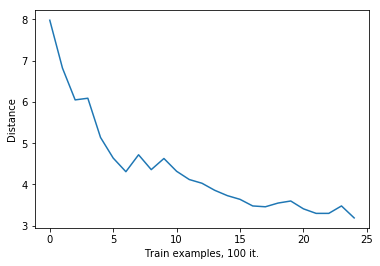

In [6]:
plt.plot(accur_list, label='Accuracy')
plt.xlabel('Train examples, 100 it.')
plt.ylabel('Distance')
plt.show()

In [140]:
print('{} = X'.format(X))
print('{} = Target'.format(np.sort(X)))
print('{} = After training prediction'.format(model.predict(X)))

[3 3 0 8 1 7 1 0 2 9] = X
[0 0 1 1 2 3 3 7 8 9] = Target
[0 1 1 2 3 3 7 8 8 9] = After training prediction
